In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

/Users/dmitrijsibircev/opt/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('train.csv')

In [3]:
y = df[['Price']]
x = df.drop('Price', axis=1)


In [4]:
X_final = pd.read_csv('test.csv')


In [5]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

x.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [6]:
class repair_data:
    
    
    def __init__(self):
        self.medians = None
                
        
    def fit(self, x):
        self.medians = x.median()
        
        
        
    def transform(self, x):
        # Rooms
        x.loc[(x['Rooms'] > 6) ^ (x['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']        
        # KitchenSquare
        x.loc[(x['KitchenSquare'] >= x['Square'] * 0.3) & (x['Square'] > 60) , 'KitchenSquare'] = 15
        x.loc[(x['KitchenSquare'] >= x['Square'] * 0.3) & (x['Square'] < 60) & (x['Square'] > 35), 'KitchenSquare'] = 10
        x.loc[(x['KitchenSquare'] >= x['Square'] * 0.3) & (x['Square'] < 35) , 'KitchenSquare'] = 7
        x.loc[(x['KitchenSquare'] < 3) , 'KitchenSquare'] = 3
        # LifeSquare
        x.loc[(x['LifeSquare'].isna() == True) ^ (x['LifeSquare'] >= x['Square']), 'LifeSquare'] = x['Square'] - x['KitchenSquare'] - 4
        # Floor & HouseFloor
        x.loc[(x['Floor'] == 0), 'Floor'] = 1
        x.loc[(x['Floor'] > x['HouseFloor']) & (x['HouseFloor'] != 0), 'Floor'] = x['HouseFloor']
        x.loc[(x['HouseFloor'] == 0), 'HouseFloor'] = x['Floor']
        # HouseYear
        x.loc[(x['HouseYear'] > 2020), 'HouseYear'] = 2020
        # Healthcare_1
        x.drop(['Healthcare_1'], axis = 1, inplace =True)
        # меняем А и В на 1 и 0 в Ecology_2 и тип на int
        x.loc[x['Ecology_2'] == 'B', 'Ecology_2'] = 0
        x.loc[x['Ecology_2'] == 'A', 'Ecology_2'] = 1
        x.loc[x['Ecology_2'] == 1]
        x['Ecology_2'] = x['Ecology_2'].astype(int)
        # меняем А и В на 1 и 0 в Ecology_3 и тип на int
        x.loc[x['Ecology_3'] == 'B', 'Ecology_3'] = 0
        x.loc[x['Ecology_3'] == 'A', 'Ecology_3'] = 1
        x.loc[x['Ecology_3'] == 1]
        x['Ecology_3'] = x['Ecology_3'].astype(int)
        # меняем А и В на 1 и 0 в Shops_2 и тип на int
        x.loc[x['Shops_2'] == 'B', 'Shops_2'] = 0
        x.loc[x['Shops_2'] == 'A', 'Shops_2'] = 1
        x['Shops_2'] = x['Shops_2'].astype(int)
        
        return x
        

In [7]:
imputer = repair_data()

imputer.fit(x) 

x = imputer.transform(x)

X_final = imputer.transform(X_final)


In [8]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.med_price_by_dist_year = None
        self.e = None
        self.dict_DistrictId_medians_HouseFloor = None
        self.type_rooms_dict = None
        
    def fit(self, x, y=None):
        
        x = x.copy()
        
        # DistrictID
        district = x['DistrictId'].value_counts()
        district = district[district > 20]  
        self.DistrictId_counts = dict(district)
        
        # DistrictId_medians_square
        f = self.DistrictId_counts.keys()
        e = {}
        for i in f:
            u = x.loc[(x['DistrictId'] == i), 'Square']
            p = u.median()
            e.update({i:p})
        
        self.e = e
            
        # DistrictId_medians_HouseFloor
        
        dict_DistrictId_medians_HouseFloor = {}
        for num in f:
            com_HF_dist = x.loc[(x['DistrictId'] == num), 'HouseFloor']
            med_dist_HF = com_HF_dist.median()
            dict_DistrictId_medians_HouseFloor.update({num : med_dist_HF})
        
        self.dict_DistrictId_medians_HouseFloor = dict_DistrictId_medians_HouseFloor
               
        # Square_Rooms
        
        type_rooms_data = x['Rooms'].value_counts()
        type_rooms_dict = dict(type_rooms_data)
        type_rooms = type_rooms_dict.keys()
        Square_median_Rooms_dict = {}
        for num_rooms in type_rooms:
            square_rooms = x.loc[(x['Rooms'] == num_rooms), 'Square']
            median_square_rooms = square_rooms.median()
            Square_median_Rooms_dict.update({num_rooms:median_square_rooms})
            
        self.Square_median_Rooms_dict = Square_median_Rooms_dict
        
        
        # При использовании Target encoding и новых категориальных фичей
    # результаты сливаются в минус на несколько процентов, как ни крутил, без них точность прогноза выше 
        
       
        # Target encoding
        ## District
#         df = x.copy()
        
#         if y is not None:
#             df['Price'] = y.values
            
#             df['DistrictId_popular'] = df['DistrictId'].copy()
#             df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
#             self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByDistrict',
#                                                            'DistrictId_popular': 'DistrictId'})
            
#         ## floor, year
#         if y is not None:
#             df['Price'] = y.values
#             df = self.floor_to_cat(df)
#             df = self.year_to_cat(df)
#             self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByFloorYear'})
            
#         ## district, house_year
#         if y is not None:
#             df['Price'] = y.values
#             df['DistrictId_count'] = x['DistrictId'].map(self.DistrictId_counts)
#             df['DistrictId_count'].fillna(5, inplace=True)
#             df = self.district_to_cat(df)
#             df = self.year_to_cat(df)
#             self.med_price_by_dist_year = df.groupby(['year_cat', 'district_cat'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByDistrictYear'})
             
    def transform(self, x):
        
        # DistrictId
        x['DistrictId_count'] = x['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}

        # feature_importance показывает, что от данной фичи толку 0
        
#         x['new_district'] = 0
#         x.loc[x['DistrictId_count'].isna(), 'new_district'] = 1
        
        x['DistrictId_count'].fillna(5, inplace=True)
        
        # DistrictId_medians_square

        x['DistrictId_median_square'] = x['DistrictId'].map(self.e)
        
        # DistrictId_medians_HouseFloor
                   
        x['DistrictId_median_HouseFloor'] = x['DistrictId'].map(self.dict_DistrictId_medians_HouseFloor)
        
        # Square_median_Rooms
        
        x['Square_median_Rooms'] = x['Rooms'].map(self.Square_median_Rooms_dict)

        
        # При использовании Target encoding и новых категориальных фичей
    # результаты сливаются в минус на несколько процентов, как ни крутил, без них точность прогноза выше 
        
#         # More categorical features
#         x = self.floor_to_cat(x)  # + столбец floor_cat
#         x = self.year_to_cat(x)   # + столбец year_cat
#         x = self.district_to_cat(x)   
        
        
        return x
    
    # При использовании Target encoding и новых категориальных фичей
    # результаты сливаются в минус на несколько процентов, как ни крутил, без них точность прогноза выше 
        
#         # Target encoding
#         if self.med_price_by_district is not None:
#             x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#         if self.med_price_by_floor_year is not None:
#             x = x.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
       
#         if self.med_price_by_dist_year is not None:
#             x = x.merge(self.med_price_by_dist_year, on=['year_cat', 'district_cat'], how='left')
        
#         return x
    
#     @staticmethod
#     def floor_to_cat(x):
        
#         x['floor_cat'] = np.nan
        
#         x.loc[x['Floor'] < 3, 'floor_cat'] = 1  
#         x.loc[(x['Floor'] >= 3) & (x['Floor'] <= 5), 'floor_cat'] = 2
#         x.loc[(x['Floor'] > 5) & (x['Floor'] <= 9), 'floor_cat'] = 3
#         x.loc[(x['Floor'] > 9) & (x['Floor'] <= 15), 'floor_cat'] = 4
#         x.loc[x['Floor'] > 15, 'floor_cat'] = 5
# #         x['floor_cat'] = x['floor_cat'].astype(int)
            
#         return x
     
#     @staticmethod
#     def year_to_cat(x):
        
#         x['year_cat'] = np.nan
        
#         x.loc[(x['HouseYear'] <= 1970), 'year_cat'] = 1
#         x.loc[(x['HouseYear'] > 1970) & (x['HouseYear'] <= 1976), 'year_cat'] = 2
#         x.loc[(x['HouseYear'] > 1976) & (x['HouseYear'] <= 1977), 'year_cat'] = 3
#         x.loc[(x['HouseYear'] > 1977) & (x['HouseYear'] <= 1995), 'year_cat'] = 4
#         x.loc[(x['HouseYear'] > 1995) & (x['HouseYear'] <= 2010), 'year_cat'] = 5
#         x.loc[(x['HouseYear'] > 2010), 'year_cat'] = 6
# #         x['year_cat'] = x['year_cat'].astype(int)
        
#         return x
        
#     @staticmethod
#     def district_to_cat(x):
        
#         x['district_cat'] = np.nan
        
#         x.loc[x['DistrictId_count'] < 50, 'district_cat'] = 1
#         x.loc[(x['DistrictId_count'] >= 50) & (x['DistrictId_count'] < 100), 'district_cat'] = 2
#         x.loc[(x['DistrictId_count'] >= 100) & (x['DistrictId_count'] < 200), 'district_cat'] = 3
#         x.loc[(x['DistrictId_count'] >= 200) & (x['DistrictId_count'] < 300), 'district_cat'] = 4
#         x.loc[(x['DistrictId_count'] >= 300) & (x['DistrictId_count'] < 450), 'district_cat'] = 5
#         x.loc[x['DistrictId_count'] >= 450, 'district_cat'] = 6
# #         x['district_cat'] = x['district_cat'].astype(int)
            
#         return x
    
    
            

In [9]:
features = FeatureGenetator()
features.fit(x, y)
x = features.transform(x)
X_final = features.transform(X_final)

In [10]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DistrictId                    10000 non-null  int64  
 1   Rooms                         10000 non-null  float64
 2   Square                        10000 non-null  float64
 3   LifeSquare                    10000 non-null  float64
 4   KitchenSquare                 10000 non-null  float64
 5   Floor                         10000 non-null  float64
 6   HouseFloor                    10000 non-null  float64
 7   HouseYear                     10000 non-null  int64  
 8   Ecology_1                     10000 non-null  float64
 9   Ecology_2                     10000 non-null  int64  
 10  Ecology_3                     10000 non-null  int64  
 11  Social_1                      10000 non-null  int64  
 12  Social_2                      10000 non-null  int64  
 13

In [11]:
model = LGBMRegressor(max_depth=4,
                             min_samples_leaf=10,
                             n_estimators=600,
                             random_state=42,
                             n_jobs = 5
                             )

cv_score = cross_val_score(model, x, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.747 +- 0.020


In [12]:
model.fit(x, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=600, n_jobs=5, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [13]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final


In [14]:
preds_final.shape

(5000, 2)

In [15]:
preds_final.to_csv('predictions.csv', index=False)

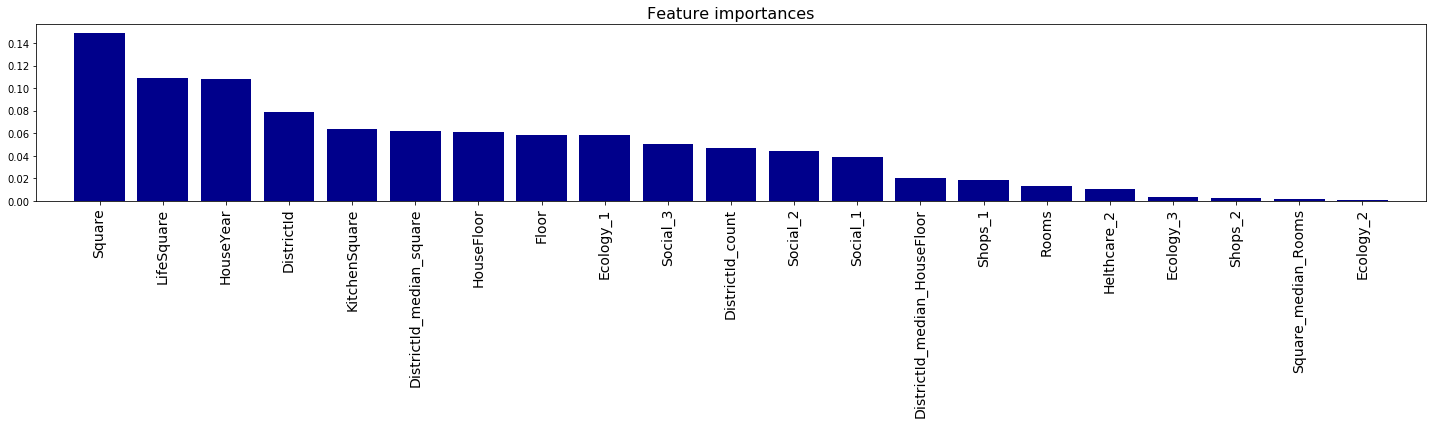

In [16]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=x)